In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from fastai.basics import *

## MNIST SGD 

In [13]:
path = Path("/home/ricky/Desktop/repos/fastai_course/data/")/"mnist"

In [14]:
path.ls()

[PosixPath('/home/ricky/Desktop/repos/fastai_course/data/mnist/mnist.pkl.gz')]

In [17]:
with gzip.open(path/"mnist.pkl.gz", "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

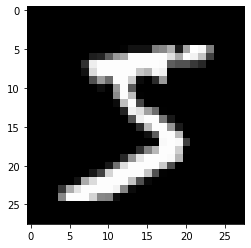

In [18]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")

In [19]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [20]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [21]:
x, y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [29]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)
        
    def forward(self, xb):
        return self.lin(xb)

In [30]:
model = Mnist_Logistic().cuda()

In [31]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [32]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [33]:
model(x).shape

torch.Size([64, 10])

In [34]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [35]:
lr=2e-2

In [36]:
loss_func = nn.CrossEntropyLoss()

In [37]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [38]:
losses = [update(x, y, lr) for x, y in data.train_dl]

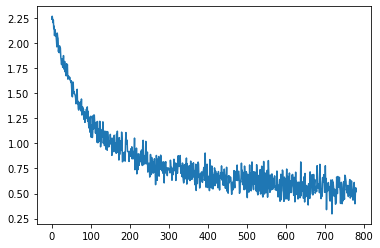

In [39]:
plt.plot(losses)

In [40]:
x_train.shape

torch.Size([50000, 784])

In [41]:
50000/64

781.25

In [42]:
len(losses)

781

In [43]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [44]:
model = Mnist_NN().cuda()

In [46]:
loses = [update(x, y, lr) for x, y in data.train_dl]

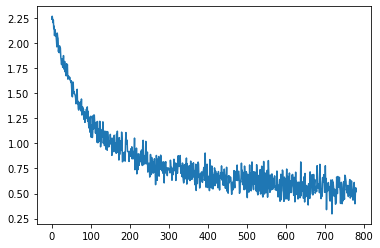

In [47]:
plt.plot(losses)

In [48]:
model = Mnist_NN().cuda()

In [49]:
def update(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [50]:
losses = [update(x, y, 1e-3) for x,y in data.train_dl]

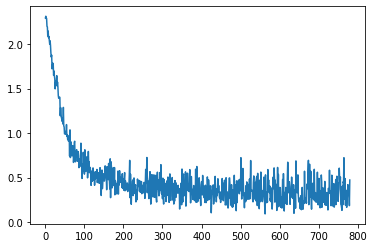

In [52]:
plt.plot(losses);

In [54]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


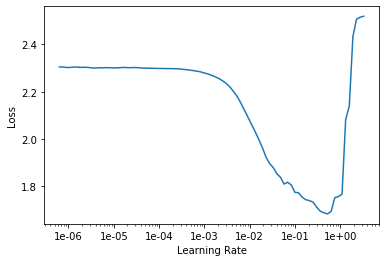

In [56]:
learn.lr_find()
learn.recorder.plot()

In [60]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.149422,0.135515,0.962800,00:03


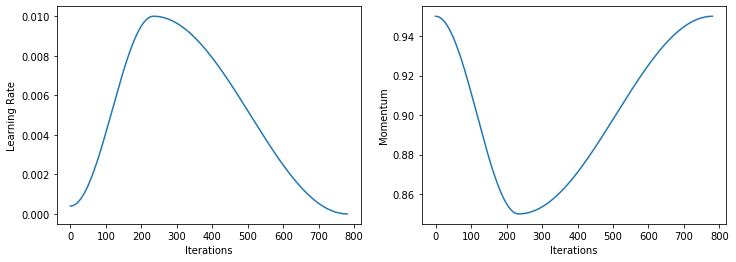

In [62]:
learn.recorder.plot_lr(show_moms=True)

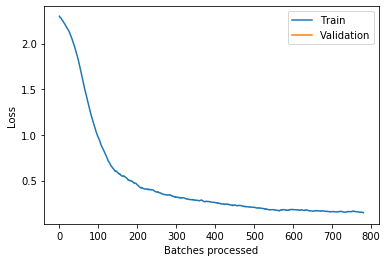

In [63]:
learn.recorder.plot_losses()